# 12. GO/STOP! - Object Detection 시스템 만들기 [프로젝트]


|평가문항|상세기준|
|:-----|:-----|
|1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.|
|2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.|
|3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|	테스트 수행결과 90% 이상의 정확도를 보였다.|

In [ ]:
#필요한 라이브러리 불러오기
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content'

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling kitti-train.tfrecord...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling kitti-validation.tfrecord...:   0%|          | 0/423 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling kitti-test.tfrecord...:   0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /content/kitti/3.2.0. Subsequent calls will reuse this data.


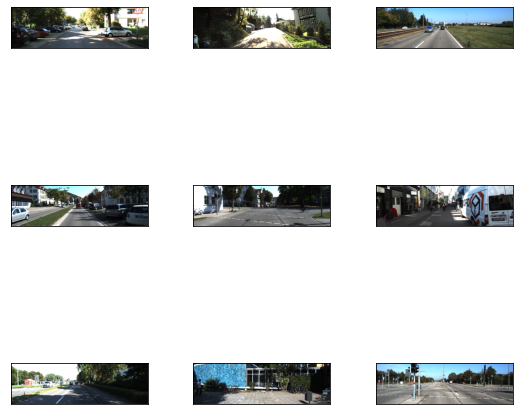

In [ ]:
_ = tfds.show_examples(ds_train, ds_info)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/content/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(s

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(11,), dtype=float32, numpy=
array([-2.11, -1.78, -2.09, -2.23, -2.35, -2.54, -2.81, -2.47, -2.51,
       -2.18,  1.72], dtype=float32)>, 'bbox': <tf.Tensor: shape=(11, 4), dtype=float32, numpy=
array([[0.0026738 , 0.7197415 , 0.60574865, 0.9012278 ],
       [0.29393047, 0.33601776, 0.5780481 , 0.3701454 ],
       [0.0026738 , 0.7226656 , 0.5632086 , 0.7843134 ],
       [0.06810161, 0.6013974 , 0.56925136, 0.64955574],
       [0.15545455, 0.44996768, 0.56187165, 0.50419223],
       [0.18834224, 0.6175202 , 0.5830481 , 0.6975121 ],
       [0.25082886, 0.5335945 , 0.57272726, 0.57205975],
       [0.1067647 , 0.6050242 , 0.5366845 , 0.6629483 ],
       [0.28045455, 0.57205975, 0.5798396 , 0.60936993],
       [0.20093583, 0.5820517 , 0.5693583 , 0.65008885],
       [0.3732353 , 0.39501616, 0.54114974, 0.46180937]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(11, 3), dtype=float

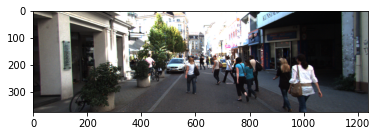

In [ ]:
sample = ds_train.take(1)

for example in sample:
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [ ]:
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.

In [ ]:
print(img.size)

(1238, 374)


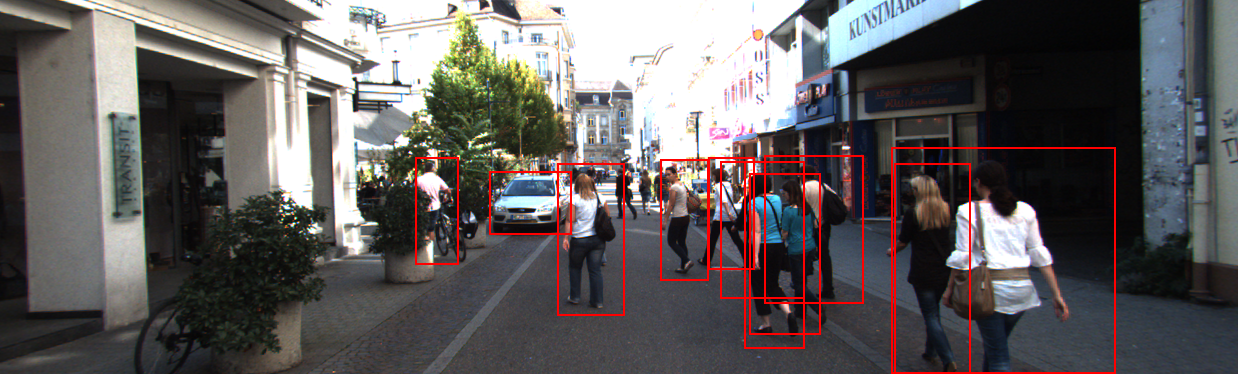

In [ ]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 데이터 준비

In [ ]:
#독립적인 함수를 각각 작성합니다.
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )

    return image, boxes

In [ ]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0

    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training: #학습 중인 경우 랜덤한 최소 크기 선택:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side: #이미지 크기 조정 비율 계산
        ratio = max_side / tf.reduce_max(image_shape) #최대 크기를 초과하지 않도록 비율 조정
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32)) #이미지 크기 조정
    padded_image_shape = tf.cast( #패딩된 이미지 크기 계산
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box( #이미지 패딩
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [ ]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )
#boxes[..., :2]: xmin 및 ymin 좌표에 해당하는 각 경계 상자의 처음 두 값을 선택
#boxes[..., 2:]: xmax 및 ymax 좌표에 해당하는 각 경계 상자의 마지막 두 값을 선택
#(boxes[..., :2] + boxes[..., 2:]) / 2.0: 각 경계 상자에 대해 xmin + xmax 및 ymin + ymax의 평균을 계산
#경계 상자의 중심 좌표(center_x, center_y)를 제공

#boxes[..., 2:] - boxes[..., :2]: xmax와 xmin 좌표의 차이를 계산하여 너비를 구하고,
#마찬가지로 ymax와 ymin 좌표의 차이를 계산하여 각 경계 상자의 높이를 얻는다.

이제 준비된 함수들을 연결해 줍니다.

In [ ]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 인코딩

In [ ]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]] #앵커 박스의 크기를 조절하는 스케일(scale) 리스트

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self): #앵커 박스의 차원을 계산
        anchor_dims_all = []
        for area in self._areas: #리스트에 대해 반복하면서 각 면적에 대한 앵커 박스의 차원을 계산
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level): #특정 레벨에서의 앵커 박스를 생성
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5 #특징 맵 내 각 위치의 x와 y 좌표
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width): # 모든 레벨에 대해 앵커 박스를 생성
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0) #계산된 앵커 박스들을 하나의 텐서로 합쳐서 반환

In [ ]:
def convert_to_corners(boxes):
    #경계 상자의 왼쪽 위(xmin, ymin) 및 오른쪽 아래(xmax, ymax) 모서리의 좌표를 계산
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    # 두 경계 상자 세트 사이의 IoU(Intersection over Union)를 계산
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    #교차점의 왼쪽 상단(lu)과 오른쪽 하단(rd) 모서리의 좌표를 계산
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    #교차 영역과 개별 경계 상자 영역이 계산
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    #Union Area를 계산하며, IoU는 intersection_area/union_area로 계산
    #계산된 IoU 값은 tf.clip_by_value를 사용하여 0과 1 사이에서 잘림
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [ ]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor( #경계 상자 인코딩의 분산을 나타내는 텐서
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        # IoU 임계값을 기준으로 앵커 상자를 Ground Truth 상자와 일치시킨다.
        # 앵커 상자와 Ground Truth 상자 사이의 IoU 행렬을 계산
        #각 앵커 박스의 최대 IoU를 계산하고, 일치하는 ground truth를 식별하고, 긍정, 부정 및 무시 일치에 대한 마스크를 생성
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        #확실하게 일치하는 앵커 상자에 대한 상자 회귀 목표를 계산
        box_target = tf.concat(
            [
                #Ground Truth 상자를 앵커 상자 좌표 공간으로 변환하여 상자 회귀 대상을 계산
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        #중심 좌표의 차이와 너비 및 높이의 대수 차이를 _box_variance로 나눈다.
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        #ground truth information와 함께 단일 훈련 샘플(이미지)을 인코딩
        #주어진 이미지 크기에 맞는 앵커박스를 생성
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        # _match_anchor_boxes로 상자를 Ground Truth 상자와 일치시킨다.
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        #compute_box_target을 사용하여 상자 회귀 목표를 계산
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        #각 앵커 상자에 대한 클래스 대상을 생성하고 부정에는 -1을, 무시하려면 -2를 설정
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        #상자 회귀 대상과 클래스 대상을 연결하여 최종 레이블 텐서를 생성
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        #훈련 샘플 배치와 관련 ground truth information를 인코딩
        #입력된 이미지 배치의 모양을 계산
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        #배치의 각 샘플을 반복하고 _encode_sample을 사용하여 인코딩
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        #ResNet 전처리를 사용하여 이미지 배치에 전처리를 적용
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

## 모델 작성

In [ ]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [ ]:
#출력 필터 수와 편향 초기화 값을 인자로 받습니다.
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    #가중치 초기화를 위해 정규 분포를 따르는 랜덤 값을 생성하는 초기화 함수를 정의
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    #최종 출력을 생성하는 합성곱 레이어를 추가
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            #3x3 커널과 스트라이드 1을 사용
            3,
            1,
            padding="same",
            # 앞서 정의한 가중치 초기화 함수를 사용하여 가중치를 초기화
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [ ]:
def get_backbone():
    #사전 훈련된 가중치를 사용하여 ResNet-50 모델의 인스턴스를 생성
    #include_top=False는 모델의 최상위(완전 연결) 레이어가 포함되지 않도록 지정
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    #ResNet-50 모델의 특정 레이어에서 출력 기능 맵을 추출
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    #ResNet-50 백본을 사용하여 새로운 tf.keras.Model을 생성
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

RetinaNet을 완성해 봅시다. Backbone + FPN + classification용 head + box용 head

In [ ]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        # 클래스 및 상자 예측 헤드에 대한 초기화를 설정하기 위해 계산
        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        #클래스 및 상자 예측 헤드를 생성하는 build_head 함수(제공되지 않음)를 사용하여 생성
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    #모델이 입력을 처리하고 출력을 생성하는 방법을 정의
    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0] #배치 크기를 계산
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        #각 특징 맵에 대한 예측을 누적
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라진다.

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta
    #바운딩 박스 회귀 손실을 계산
    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        #조건문을 사용하여 smooth L1 손실 공식을 적용하고, 마지막 축을 기준으로 손실을 합산하여 반환
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
    #focal loss for classification (Cross Entropy의 클래스 불균형 문제를 다루기 위한 개선된 버전)
    def call(self, y_true, y_pred):
        #교차 엔트로피와 시그모이드 확률을 계산
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        #클래스 레이블을 기반으로 가중치(alpha)와  focal 항(pt)을 구성
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes
    #결합된 손실을 계산
    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        #박스와 클래스 레이블 및 예측을 분리
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        #원-핫 인코딩을 사용하여 클래스 레이블을 구성
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        #양성 샘플 및 무시 샘플을 위한 마스크를 계산
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        #분류 및 박스 손실을 각각의 손실 함수를 사용하여 계산
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

##  모델 학습

In [ ]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
#조각별 상수 학습률 감소를 구현한 클래스
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

이제 데이터 전처리를 위한 파이프라인도 만들어 줍니다.

In [ ]:
#훈련 및 검증 데이터셋을 로드하고 전처리

label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

#데이터셋 처리 파이프라인을 병렬로 실행하기 위해 tf.data의 AUTOTUNE을 사용
autotune = tf.data.AUTOTUNE

#train 전처리
#num_parallel_calls를 이용하여 데이터 전처리를 병렬로 처리
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch( #배치 단위로 데이터셋을 생성하며, 패딩을 추가
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True #마지막 배치가 작을 경우 버립니다.
)
train_dataset = train_dataset.map( #배치 데이터의 라벨을 인코딩
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune) #데이터셋을 전처리한 후 미리 메모리에 올려놓아 효율적인 학습을 돕는다.

#validation 전처리
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)


In [ ]:
model_dir = '/content'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 5

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/5
3173/3173 [==============================] - 1632s 496ms/step - loss: 2.4211 - val_loss: 1.6286

Epoch 00001: saving model to /content/weights_epoch_1
Epoch 2/5
3173/3173 [==============================] - 1571s 495ms/step - loss: 1.0910 - val_loss: 1.2898

Epoch 00002: saving model to /content/weights_epoch_2
Epoch 3/5
3173/3173 [==============================] - 1570s 495ms/step - loss: 0.7888 - val_loss: 1.1102

Epoch 00003: saving model to /content/weights_epoch_3
Epoch 4/5
3173/3173 [==============================] - 1571s 495ms/step - loss: 0.6210 - val_loss: 1.0158

Epoch 00004: saving model to /content/weights_epoch_4
Epoch 5/5
3173/3173 [==============================] - 1572s 495ms/step - loss: 0.5176 - val_loss: 0.9831

Epoch 00005: saving model to /content/weights_epoch_5


##  결과 확인하기

In [ ]:
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05, #최소 신뢰도 임계값
        nms_iou_threshold=0.5, #(NMS)를 위한 IoU 임계값
        max_detections_per_class=100,
        max_detections=100, #전체 이미지에서 최대 검출 수
        box_variance=[0.1, 0.1, 0.2, 0.2] #박스 예측에 적용할 분산(편차)을 나타내는 값
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )
    #앵커 박스와 박스 예측 값을 이용하여 박스 예측을 디코딩하는 메서드
    #예측된 상대적인 값들을 앵커 박스와 편차를 이용하여 절대적인 좌표와 크기로 변환
    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    #디코딩된 예측 결과를 기반으로 최종 검출된 객체를 생성하는 메서드
    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2]) #입력 이미지 크기를 이용하여 앵커 박스들을 생성
        box_predictions = predictions[:, :, :4] #예측 결과에서 박스에 관련된 부분을 슬라이싱하여 가져온다.
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        #검출된 박스들에 대해 NMS를 적용하여 최종 검출 결과를 반환
        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
# 예측 결과를 디코딩하여 검출된 객체 정보인 detections를 생성
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
#추론용 모델을 생성
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [ ]:
#모델의 추론 결과를 시각화 함수
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()

    height_v = [ ]
    width_v = [ ]
    class_n = [ ]

    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box #경계 상자의 좌표(x1, y1, x2, y2)를 추출
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1 #경계 상자의 너비와 높이를 계산
        #경계 상자를 나타내는 '사각형' 패치를 만듬
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )

        #픽셀의 크기 출력
        x1_v = x1.numpy()
        x2_v = x2.numpy()
        y1_v = y1.numpy()
        y2_v = y2.numpy()
        w_v = x2_v - x1_v
        h_v = y2_v - y1_v
        height_v.append(h_v)
        width_v.append(w_v)

        ax.add_patch(patch)
        #축에 텍스트 주석을 추가하여 형식화된 클래스 이름과 점수를 표시
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
        text_s = text.split(":")
        text_s = text_s[0].strip()
        class_n.append(text_s)
    plt.show()
    return ax, height_v, width_v, class_n

In [ ]:
def prepare_image(image):
    #이미지를 크기 조정하고 패딩, 세 번째 반환값 ratio는 이미지의 크기 조정 비율
    image, _, ratio = resize_and_pad_image(image, training=False)
    # ResNet 모델에 입력 이미지를 전처리하기 위해 사용되며, 이미지의 픽셀 값 범위를 조정하고 정규화
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


In [ ]:
image.shape

TensorShape([375, 1242, 3])

class 종류는 : 'Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/go_3.png'
#학습된 모델의 최신 체크포인트 파일 경로를 가져옵니다.
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

def self_drive_assist(img_path, size_limit=300):
    #클래스 이름으로 변환하기 위한 변환 함수
    int2str = dataset_info.features["objects"]["type"].int2str

    #이미지를 열어 tesnsor로 변환
    image = Image.open(img_path)
    image = tf.cast(image, dtype=tf.float32)

    #크기 조정 및 정규화
    input_image, ratio = prepare_image(image)
    #사전에 정의한 추론 모델을 사용하여 입력 이미지로부터 검출 정보를 예측
    detections = inference_model.predict(input_image)
    #예측된 검출의 유효한 개수를 가져온다
    num_detections = detections.valid_detections[0]
    #예측된 검출의 클래스 인덱스를 클래스 이름으로 변환하여 리스트로 가져온다.
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    #이미지와 검출 정보를 시각화하고 클래스별 높이와 너비 정보를 반환
    returned_ax, height_v, width_v, class_name = visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    stop = "Stop"
    go = "Go"
    #클래스별 높이와 넓이 출력
    for i in range(len(class_name)):
        print(class_name[i],height_v[i],width_v[i])

    #사람이 있을경우
    person = 0
    for i in range(len(class_name)):
        if class_name[i] == "Pedestrian" or class_name[i] == "Person_sitting":
            person = 1
            return stop

    #사람이 없을 경우
    if person == 0:
        for i in range(len(class_name)):
            if class_name[i] == "Car" or class_name[i] =="Van" or class_name[i] =="Truck" or class_name[i] =="Tram":
                if height_v[i] >= size_limit or width_v[i] >= size_limit:
                    return stop
            else:
                return go
        return go


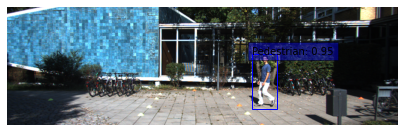

Pedestrian 171.9312 78.651306


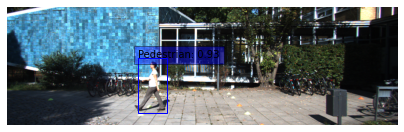

Pedestrian 172.34464 91.27664


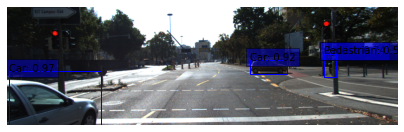

Car 168.82143 290.52826
Car 42.096207 116.54462
Cyclist 74.26758 37.89734
Pedestrian 71.98967 37.24408


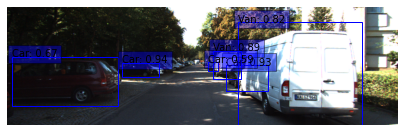

Car 45.80252 114.74744
Car 82.47797 134.43396
Van 90.08768 87.89386
Van 331.874 394.33496
Car 157.85983 337.6372
Car 26.560577 32.26758


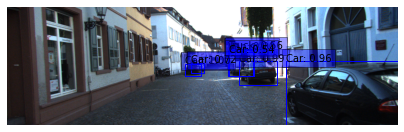

Car 37.08107 50.11975
Car 76.53979 117.70734
Car 206.27335 360.58588
Van 84.58508 82.12451
Car 31.579346 41.71814
Truck 86.03233 78.84711
Car 74.86421 80.45941


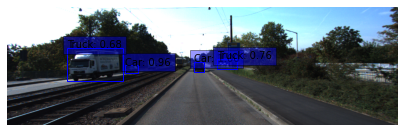

Car 31.290115 33.962097
Car 24.291275 42.409027
Truck 31.500046 60.623047
Truck 104.47772 177.04836


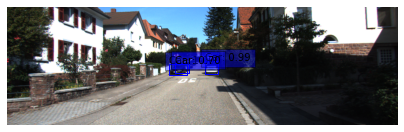

Car 36.63762 56.0719
Car 41.437378 40.091064
Car 30.336792 45.04425


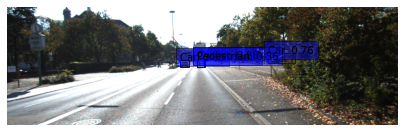

Car 22.483536 29.067505
Cyclist 25.037231 24.133667
Car 31.952744 85.37964
Pedestrian 24.15561 24.984741


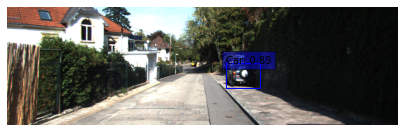

Car 77.148224 109.977356


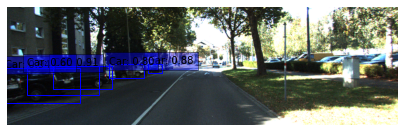

Car 110.69367 239.02182
Car 75.40372 186.71631
Car 27.03476 42.856903
Car 43.609436 112.3808
Car 91.65414 230.40186
90점입니다.


In [ ]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

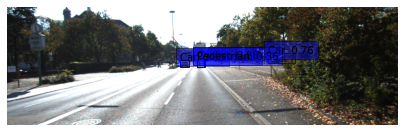

Car 22.483536 29.067505
Cyclist 25.037231 24.133667
Car 31.952744 85.37964
Pedestrian 24.15561 24.984741
Stop


In [ ]:
#오답인 이미지
print(self_drive_assist(img_path))

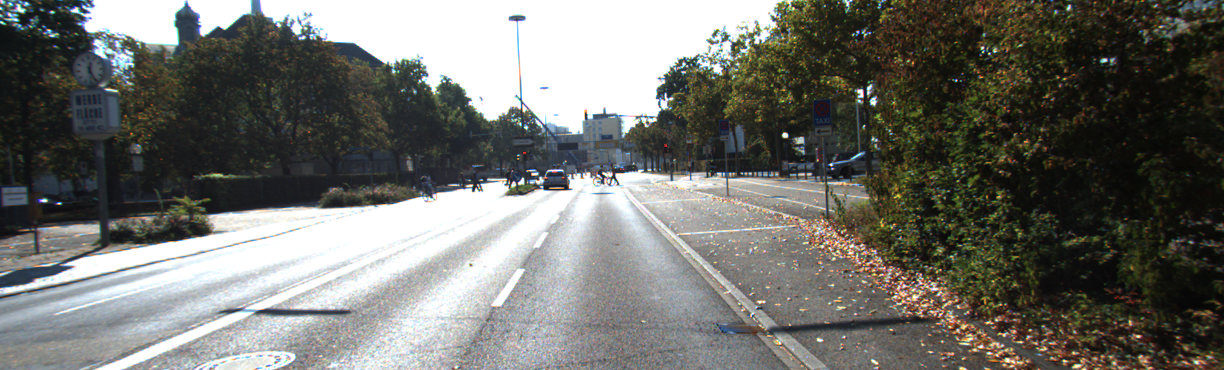

In [ ]:
img = os.getenv('HOME')+'/aiffel/object_detection/data/go_3.png'
image = Image.open(img)
image.show()